## Udacity Self Driving Car Engineer Nanodegree Project: 
### Advanced Lane Lines

# Goal

The goal of this project is to design and implement a traffic lane line detector. It is a spin-off of the first traffic lane detector project assinged at the beginning of the Self Driving Car Engineer Nanodegree; however, in this project, the lane detector is designed to be resiliant to camera distortion, brightness, and color.

# Library Import

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #BGR not RGB
%matplotlib inline
from moviepy.editor import VideoFileClip
from collections import deque

# Introduction

## Advanced Lane Detector Pipeline

1a. As an experiment, from a collection of chessboard images taken from several different perspectives, derive the camera calibration matrix and camera distortion coefficients. The distortion coefficients will help develop a distortion correction matrix to apply to a distorted image. This results in an undistorted image.

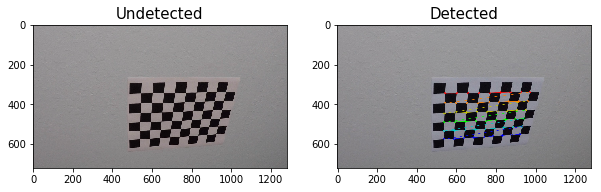

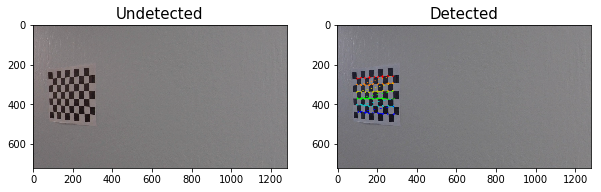

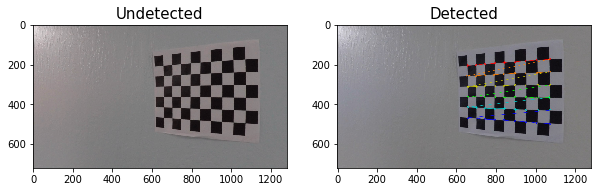

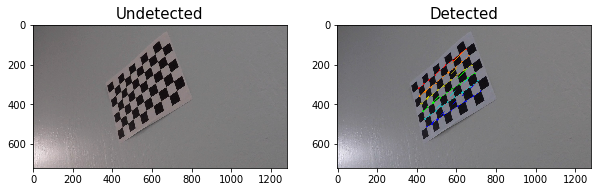

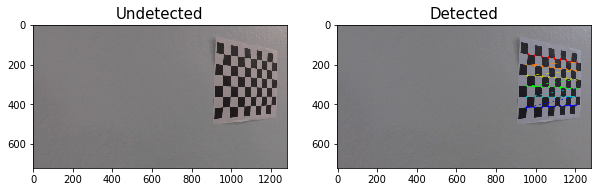

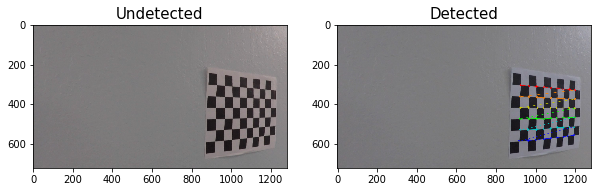

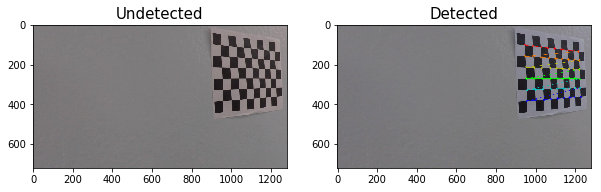

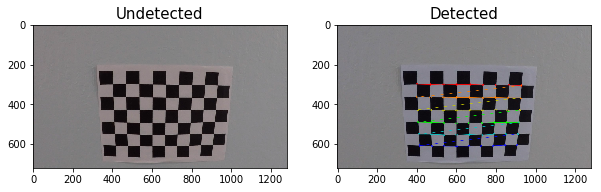

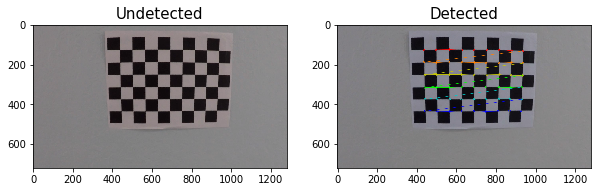

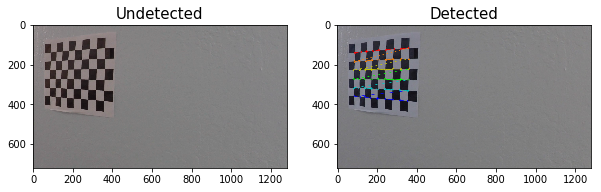

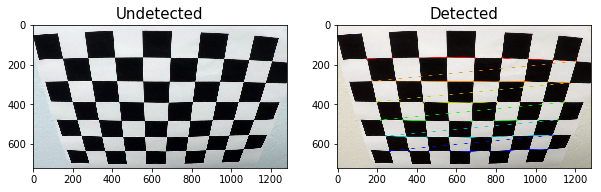

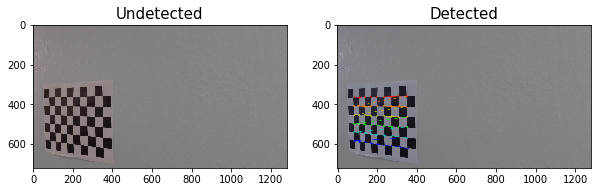

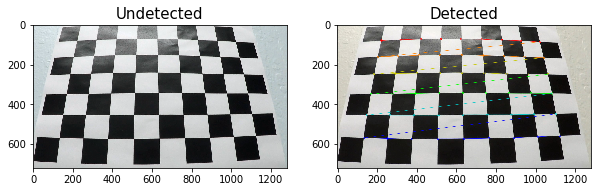

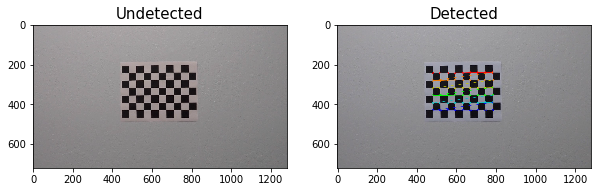

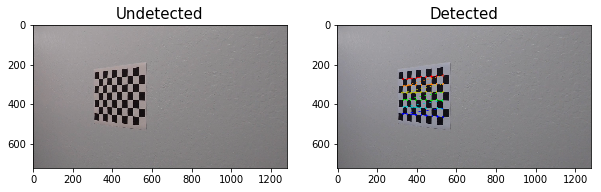

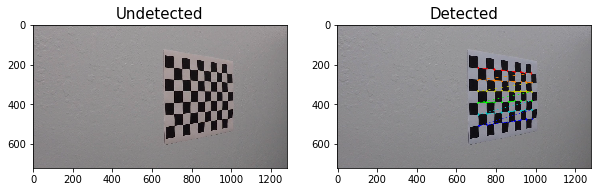

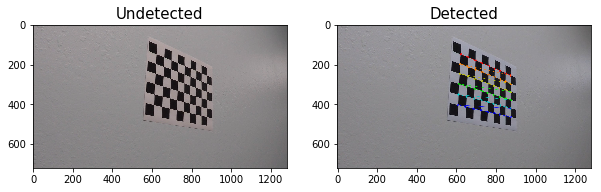

In [2]:
def display_side_by_side_images(left_image,
                                right_image,
                                left_title,
                                right_title,
                                fontsize=15,
                                tight_layout=False):
    arg0, (ax1, ax2) = plt.subplots(1,
                                   2, 
                                   figsize=(9,6))
    if tight_layout:
        arg0.tight_layout()
    ax1.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
    ax1.set_title(left_title, fontsize=15)
    ax2.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
    ax2.set_title(right_title, fontsize=fontsize)

##########################################################################
objp = np.zeros((6*9,3), 
                np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

image_names = glob.glob('camera_cal/calibration*')
img = cv2.imread(image_names[0])

##########################################################################


def chessboard_distortion_correction(image_names):
    for image_name in image_names:
        image = cv2.imread(image_name)
        gray_image = cv2.cvtColor(image, 
                                  cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_image, 
                                                 (9,6), 
                                                 None)
        
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            cv2.drawChessboardCorners(image, 
                                      (9,6), 
                                      corners, ret)
            arg0, (ax1, ax2) = plt.subplots(1,
                                            2,
                                            figsize=(10,10))
            ax1.imshow(cv2.cvtColor(mpimg.imread(image_name), 
                                    cv2.COLOR_BGR2RGB))
            ax1.set_title('Undetected', 
                          fontsize = 15)
            ax2.imshow(cv2.cvtColor(image, 
                                    cv2.COLOR_BGR2RGB))
            ax2.set_title('Detected', 
                          fontsize=15)
    return

chessboard_distortion_correction(image_names)

1b. Repeat step 1a but for real driving images.

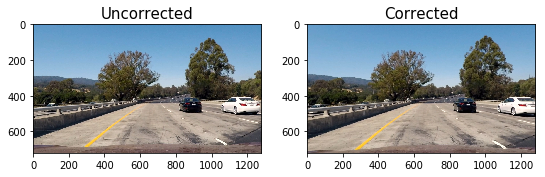

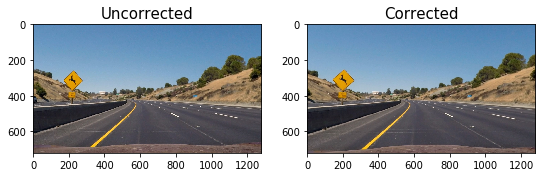

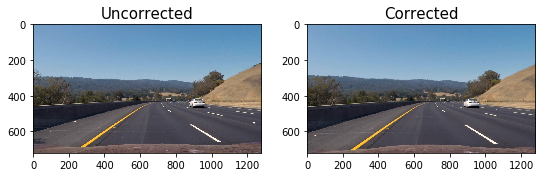

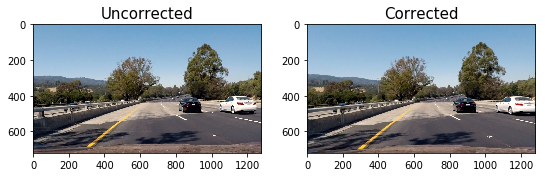

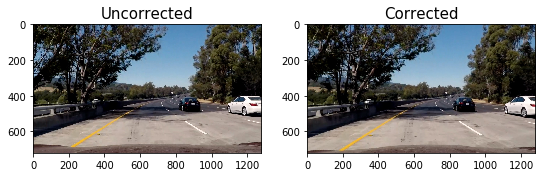

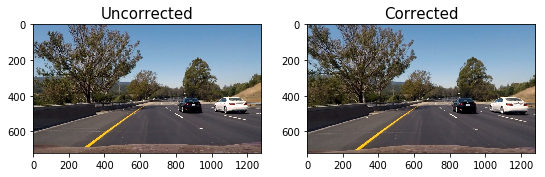

In [3]:
# def display_side_by_side_images(left_image,
#                                 right_image,
#                                 left_title,
#                                 right_title,
#                                 fontsize=15):
#     arg0, (ax1, ax2) = plt.subplots(1,
#                                    2, 
#                                    figsize=(9,6))
#     ax1.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
#     ax1.set_title(left_title, fontsize=15)
#     ax2.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
#     ax2.set_title(right_title, fontsize=fontsize)

def distortion_correction(image_name, 
                          display=True, 
                          read=True):
    if read:
        image = cv2.imread(image_name)
    image_size = (image.shape[1], 
                  image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints, 
                                                       image_size, 
                                                       None, 
                                                       None)
    undistorted_image = cv2.undistort(image, 
                              mtx, 
                              dist, 
                              None, 
                              mtx)
    if display:
        display_side_by_side_images(image,
                                   undistorted_image,
                                   'Uncorrected',
                                   'Corrected',
                                   fontsize=15)
    else:
        return undistorted_image

image_names = glob.glob('test_images/test*')
for image_name in image_names:
    distortion_correction(image_name, 
                          display=True,
                         read=True)
    

1c. Given an undistorted image, apply a perspective transformation to the warp the image to a bird's-eye-view (in the case of detecting traffic lane lines, this transformation will transform the perspective of the image to a bird's-eye-view of the road). This will make the curves look more prominent as the distorted image makes traffic lane lines appear relatively straight, converging at some vanishing point, which isn't how lane lines appear in real life. To fix this, it is best to transform the image's perspective to a bird's-eye-view, allowing our code to model traffic lane line curves with polynomials more accurately. Traffic lane lines that curve towards the right or left appear straight before the perspective transformation whereas they appear curved right or left, respectively, after the transformation.

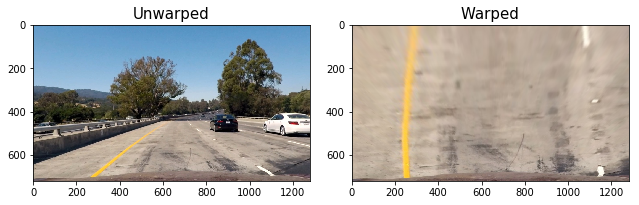

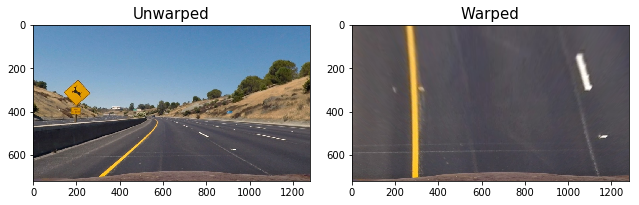

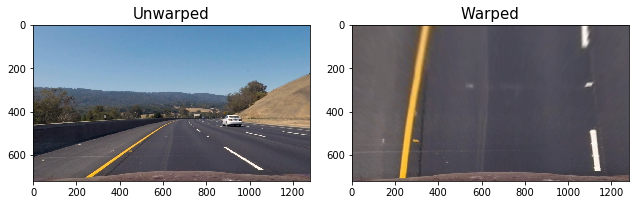

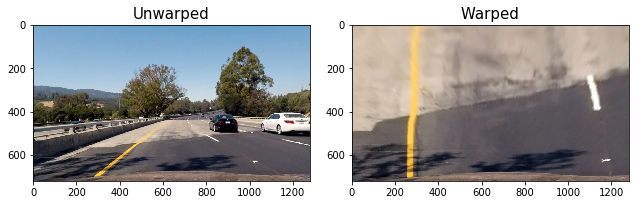

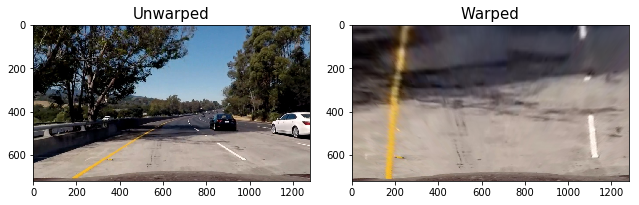

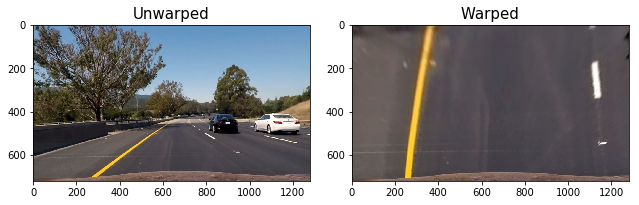

In [4]:
def birds_eye_perspective_image(image_name, 
                                    display=True,
                                   read = True,
                                   tight_layout=True):
        undistorted_image = distortion_correction(image_name,
                                                 display=False,
                                                 read=read)
        undistorted_image_size = (undistorted_image.shape[1],
                                 undistorted_image.shape[0])
        offset = 50
        source = np.float32([[490, 482],
                             [810, 482],
                            [1250, 720],
                             [40, 720]])
        destination = np.float32([[0, 0], 
                                  [1280, 0], 
                                  [1250, 720],
                                  [40, 720]])
        M = cv2.getPerspectiveTransform(source, 
                                        destination)
        birds_eye_warped_image = cv2.warpPerspective(undistorted_image,
                                                     M,
                                                     undistorted_image_size)
        if display:
            display_side_by_side_images(undistorted_image,
                                        birds_eye_warped_image,
                                        'Unwarped',
                                        'Warped',
                                        fontsize=15,
                                        tight_layout=tight_layout)
        else:
            return birds_eye_warped_image,M
        
image_names = glob.glob('test_images/test*')
for image_name in image_names:
    birds_eye_perspective_image(image_name,
                                   display=True,
                                   read=True,
                                   tight_layout=True)

d. Given a warped, undistorted image, isolate pixels corresponding to traffic lane lines. To do this, apply color thresholds to create a bit-map of the image where the key corresponds to the coordiantes of the image and the value corresponds to either a traffic lane line or not (1 for traffic lane line and 0 otherwise). In order to find the right thresholds for a given color channel, a bit of trial and error was necessary. A combination of the thresholds from the HSL (Hue-Saturation-Luminance), CIELAB (CIE Luminance-AB), and HSV (Luminance-UV) colorspaces yield applied to a warped, undistorted traffic lane image yields a warped, undistorted, image with well-defined traffic lane lines. For the following thresholds HLS [170,255], LUV [215,255], and CIELAB [140,205], the Saturation component from HLS colorspace, the Luminance component from the HSV colorspace, and the B component from the CIELAB colorspace clearly identified the traffic lane lines in their corresponding images.

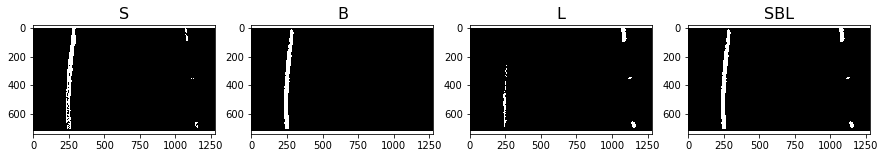

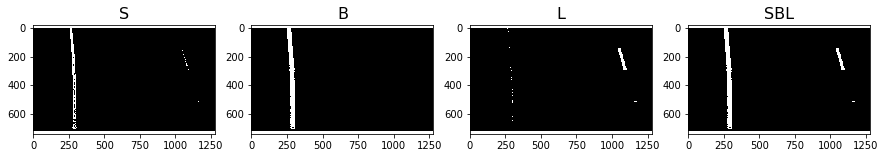

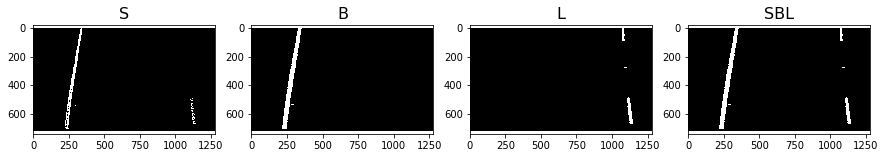

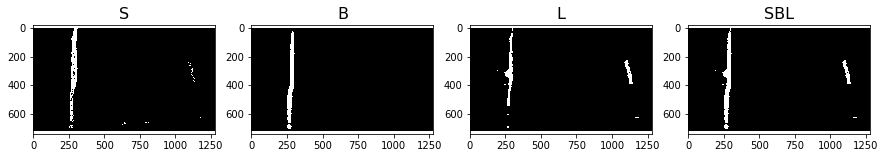

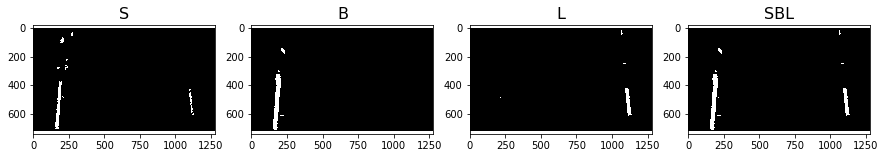

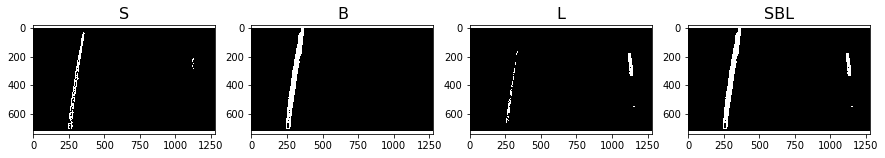

In [5]:
def isolated_traffic_lane_line_image(image_name,
                                    display=True,
                                    tight_layout=True):
    birds_eye_perspective_image_image, M = birds_eye_perspective_image(image_name,
                                                                display=False,
                                                                read=True,
                                                                tight_layout=tight_layout)
    #Intersection of HLS, LUV, and CIELAB colorspaces (S component from HL[S], L component from [L]UV, and B component from CIELA[B])
    
    S_component = cv2.cvtColor(birds_eye_perspective_image_image, cv2.COLOR_BGR2HLS)[:,:,2]
    L_component = cv2.cvtColor(birds_eye_perspective_image_image, cv2.COLOR_BGR2LUV)[:,:,0]
    B_component = cv2.cvtColor(birds_eye_perspective_image_image, cv2.COLOR_BGR2Lab)[:,:,2]
    
    S_component_binary = np.zeros_like(S_component)
    L_component_binary = np.zeros_like(L_component)
    B_component_binary = np.zeros_like(B_component)
    
    S_component_binary[(S_component > 170) & (S_component < 255)] = 1
    B_component_binary[(B_component > 165) & (B_component < 210)] = 1
    L_component_binary[(L_component > 215) & (L_component < 255)] = 1
    
    SBL_components_binary = np.zeros_like(S_component_binary)
    SBL_components_binary[(L_component_binary == 1) | (B_component_binary == 1)] = 1
    
    if display:
        arg0, (ax1, ax2,ax3, ax4) = plt.subplots(1, 4, sharey='col', sharex='row', figsize=(15,2))
        
        ax1.set_title('S', fontsize=16)
        ax1.imshow(S_component_binary, cmap='gray')
        ax2.set_title('B', fontsize=16)
        ax2.imshow(B_component_binary, cmap='gray')
        ax3.set_title('L', fontsize=16)
        ax3.imshow(L_component_binary, cmap='gray')
        ax4.set_title('SBL', fontsize=16)
        ax4.imshow(SBL_components_binary, cmap='gray')
    else:
        return SBL_components_binary

image_names = glob.glob('test_images/test*')
for image_name in image_names:
    isolated_traffic_lane_line_image(image_name,
                                    display=True,
                                    tight_layout=True)

e. Given a warped, undistorted, well-defined image from a set of traffic lane lines, model and highlight the traffic lane lines in the image with a polynomial. Then fill in the space between the traffic lane lines with a color-fill in order to guide the driver through the lane. It's colored purple-magenta as the color contrasts greatly from the enviornment, making it easier to see. To do this, it's necessary to not only calculate the position of the vehicle relative to the well-defined, polynomial-fit traffic lane lines, but also caluclate the radius of curvature for the current left and right traffic lane lines. With this information, filling in the gap between the left and right lane lines with a single color will be straight-forward.

f. Create a Line() class that stores information about the coordinates, current and previous intercepts, radii of curvature, line polynomial model coefficients, number of images, and class methods to help determine whether a traffic lane line has been detected, what the previous and current intercepts are, and what the radius of curvature is. h. Next, calculate the position of the vehicle relative to the well-defined, polynomial-fit traffic lane lines. Afterward, calculate the radius of curvature for the current left and right traffic lane lines.

In [7]:
class Line:
    def __init__(self):
        # Was the line detected in the last iteration?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # x values of the last n fits of the line
        self.lastx_int = None
        self.last_top = None
        
        # Radius of curvature of the line in pixel units
        self.radius = None
        
        # Polynomial coefficients averaged over the last n iterations
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Image count
        self.count = 0
        
    def poly_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
    
    def find(self, x, y):
        xvals = []
        yvals = []
        if self.found: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x) & (x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False
        return xvals, yvals, self.found
    
    def blind(self, x, y, image):
        xvals = []
        yvals = []
        if not self.found: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        #convert from pixels to meters
        ym_per_pix = 30./720
        xm_per_pix = 3.7/700
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5)/np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_increasing(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
Left,Right = Line(),Line()

g. Lastly, apply the above written Line class to process an array of driving images and output the result to an .mp4 file.

In [9]:
def process_image(image):
    
    image_size = (image.shape[1], 
                  image.shape[0])
    
    # Calibrate the camera
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                       imgpoints, 
                                                       image_size, 
                                                       None, 
                                                       None)
    # Undistort the image given the calibrated camera
    undistorted_image = cv2.undistort(image, 
                                      mtx, 
                                      dist, 
                                      None, 
                                      mtx)
    
    # Get a birds-eye view by applying a perspective transform on the undistorted image.
    offset = 0
    source = np.float32([[490, 482],
                         [810, 482],
                         [1250, 720],
                         [0, 720]])
    destination = np.float32([[0, 0], 
                              [1280, 0], 
                                 [1250, 720],
                              [40, 720]])
    M = cv2.getPerspectiveTransform(source, 
                                    destination)
    warped_image = cv2.warpPerspective(undistorted_image, 
                                       M,
                                       image_size)
    
    # Isolate the traffic lane lines by using the B component of CIELAB and the L component of LUV colorspaces
    B_component = cv2.cvtColor(warped_image, cv2.COLOR_RGB2Lab)[:,:,2]
    L_component = cv2.cvtColor(warped_image, cv2.COLOR_RGB2LUV)[:,:,0]  
    B_component_binary = np.zeros_like(B_component)
    B_component_binary[(B_component > 155) & (B_component < 205)] = 1    
    L_component_binary = np.zeros_like(L_component)
    L_component_binary[(L_component > 220) & (L_component < 255)] = 1

    LB_components_binary = np.zeros_like(B_component_binary)
    LB_components_binary[(B_component_binary == 1) | (L_component_binary == 1)] = 1
    
    # Identify all non zero pixels in the image. If the left lane pixels have a value of 1,
    # use the found_search method, otherwise use the blind_search method
    x, y = np.nonzero(np.transpose(LB_components_binary)) 

    if Left.found: 
        leftx, lefty, Left.found = Left.find(x, 
                                             y)
        
    if Right.found:
        rightx, righty, Right.found = Right.find(x, 
                                                 y)

            
    if not Right.found:
        rightx, righty, Right.found = Right.blind(x, 
                                                  y, 
                                                  LB_components_binary)
            
    if not Left.found:
        leftx, lefty, Left.found = Left.blind(x, 
                                              y, 
                                              LB_components_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Model left lane with a well-fitted polynomial model
    left_fit = np.polyfit(lefty, 
                          leftx, 
                          2)
    leftx_int, left_top = Left.poly_intercepts(left_fit)
    
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Find the average of the polynomial intercepts
    leftx = np.append(leftx, 
                      leftx_int)
    lefty = np.append(lefty, 
                      720)
    leftx = np.append(leftx, 
                      left_top)
    lefty = np.append(lefty, 
                      0)
    leftx, lefty = Left.sort_increasing(leftx, 
                                  lefty)
    
    Left.X = leftx
    Left.Y = lefty

    left_fit = np.polyfit(lefty, 
                          leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Polynomial to model left traffic lane line pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Polynomial to model right traffic lane line pixels
    right_fit = np.polyfit(righty, 
                           rightx, 
                           2)

    rightx_int, right_top = Right.poly_intercepts(right_fit)
    
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, 
                       rightx_int)
    righty = np.append(righty, 
                       720)
    rightx = np.append(rightx, 
                       right_top)
    righty = np.append(righty, 
                       0)
    
    rightx, righty = Right.sort_increasing(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Caluculate the radius of curvature for each traffic lane line in meters
    left_radius_of_curvature = Left.radius_of_curvature(leftx, lefty)
    right_radius_of_curvature = Right.radius_of_curvature(rightx, righty)
    Left.radius = left_radius_of_curvature
    Right.radius = right_radius_of_curvature
        
    # Your position relative to the center of the traffic lane lines (left and right)
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(destination, source)
    
    warp_zero = np.zeros_like(LB_components_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, 
                            warp_zero, 
                            warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, 
                                                           Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, 
                                                  Right.Y]))])
    pts = np.hstack((pts_left, 
                     pts_right))
    cv2.polylines(color_warp, np.int_([pts]), 
                  isClosed=False, 
                  color=(255,100,255), 
                  thickness = 30)
    cv2.fillPoly(color_warp, np.int_(pts), (255,0,255))
    newwarp = cv2.warpPerspective(color_warp, 
                                  Minv, 
                                  (image.shape[1], 
                                   image.shape[0]))
    result = cv2.addWeighted(undistorted_image, 
                             1, 
                             newwarp, 
                             0.5, 
                             0)
        
    #Distance from center of the traffic lane lines
    if position > 640:
        cv2.putText(result, 'You are {:.2f}m to the left of center'.format(distance_from_center), 
                    (100,150),
                    fontFace = 16, 
                    fontScale = 2, 
                    color=(255,255,255), 
                    thickness = 2)
    else:
        cv2.putText(result, 'You are {:.2f}m to the right of center'.format(distance_from_center), 
                    (100,150),
                    fontFace = 16, 
                    fontScale = 2, 
                    color=(255,255,255), 
                    thickness = 2)
    # Radius of Curvature
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)),
                (110,200),
                fontFace = 16, 
                fontScale = 2, 
                color=(255,255,255), 
                thickness = 2)
    Left.count += 1
    return result

output_video = 'output_video.mp4'
output_video_clip1 = VideoFileClip("project_video.mp4")
white_clip = output_video_clip1.fl_image(process_image)
white_clip.write_videofile(output_video)


[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing audio in output_videoTEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:01<00:00, 1071.19it/s]

[MoviePy] Done.
[MoviePy] Writing video output_video.mp4



100%|█████████▉| 1260/1261 [13:45<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



# References
1. http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
2. http://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
3. https://en.wikipedia.org/wiki/HSL_and_HSV
4. https://en.wikipedia.org/wiki/Lab_color_space
5. http://www.intmath.com/applications-differentiation/8-radius-curvature.php

# Discussion and Conclusion

Some problems I faced with completing this assignment were simply understanding the theory and the differences among HSL, HSV, CIELAB, CIELUV, RGB, BGR, and grayscale colorspaces. I had to do extensive research on the colorspaces to figure out why a particular component in the HSV colorspace (i.e. the S component in this case) yielded better traffic lane line isolation results than either the H or L components in the same colorspace. Not only was this a challenge to understand, but also figuring out how to combine the components from different colorspaces to yield the best traffic lane line isolation results was an even greater challenge. After much trial and error, I learned that there were two colorspaces worth exploring for detecting and visually isolating the left and right traffic lane lines, and those were the B or Brightness component of the CIELAB colorspace and the L or Luminance component of the HSL colorspace. To figure this out, I just shifted the binary color threshold window from a starting point of [100-200] for every colorspace's components to [150-255] and eventually narrowed it down to [155-220] on average for each colorspace I was interestd in.

As far as issues are concerned, I had a small issue trying to convert from pixels to meters to display the text on the screen (e.g. I kept getting an absurdly high number for the radius of curvature and distance from the center where the number was somewhere in the tens of thousands). The results were comical at first, but I found a solution for it eventually.

Punultimately, to improve the image processing pipelines as discussed in each code cell above, I would try to inform the blind search results of the position of the traffic lane lines in subsequent frames of the video of a particular window. This would speed up the pipeline by avoiding a brute-force search in the whole space for the traffic lane lines.

Lastly, a way to improve the pipeline would be to use a low-pass filter to avoid jitter, thereby smoothing traffic lane line detections over subsequent images.